# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt # plot
import pandas as pd
from scipy.integrate import solve_ivp  # to solve ODE system
from scipy.integrate import simps # calculate the yield with Simpson rule
from numpy import trapz # calculate the yield with trapezoid rule
from SALib.sample.morris import sample as ee_sample # sensitivity analysis
from SALib.analyze.morris import analyze as ee_analyze # sensitivity analysis
from tqdm import tqdm
import seaborn as sns # colourful plot

# Numerical parameters

In [2]:
seed = 1234
method = "Radau"
tmax = 600 # 5000 for the numerical continuation, 300 for the time series
step = tmax*10
time_list = np.linspace(0, tmax, step)
num_of_points = 200 # 

# Parameter values

r=2
K=10
aS=0.8
hS=10
KBt=190
f=1.5
nE=1
aP=0.05
alpha=0.5 # 0<alpha<1
cL=1
qL=0.01
nL=0.01
mBt=0.05
mA=0.1
mP=0.2
RP=0
sig=2
bound=20 # economic threshold

r=0.7
K=10
aS=0.18
hS=2
KBt=190
f=2
nE=1
aP=0.06
alpha=0.5 # 0<alpha<1
cL=1
qL=0.01
nL=0.01
mBt=0.04
mA=0.1
mP=0.3
RP=0
sig=2
bound=20 # economic threshold

In [3]:
r=1
K=10
aS=0.18
hS=2
KBt=190
aP=1
alpha=0.5 # 0<alpha<1
qS=0.1
mBt=0.01
mP=0.3
RP=0
sig=2
bound=20 # economic threshold

# Parasitoid release

In [4]:
def ddf(t,sig_1,value_1,bound_1): #(t,sig,A,bound)
    val = 0.0
    if value_1>bound_1:
        t_transition=0.1
        half_life_time=1e5
        decay_constant = np.log(2)/half_life_time
        val = sig_1 * np.exp(-decay_constant * (t - t_transition))
    return val
inoculative_function = ddf

def ddf(t,sig_1,value_1,value_2,bound_1): #(t,sig,A,bound)
    val = 0.0
    x0 = value_2
    x1 = x0 + sig_1
    w = 0.05
    sigmat = 1.0 / (1.0 + np.exp(-(1 - t) / w))
    if value_1>bound_1:
        val = ( x0 + (x1 - x0)*(1 - sigmat) ) # https://kitchingroup.cheme.cmu.edu/blog/2013/02/27/Smooth-transitions-between-two-constants/
    return val
inoculative_function = ddf

# Mathematical model

In [5]:
def structured_parasitism_model(
    t,
    X,
    r=r,
    K=K,
    aS=aS,
    hS=hS,
    KBt=KBt,
    aP=aP,
    alpha=alpha,
    qS=qS,
    mBt=mBt,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    C,CBt,S,SBt,P = X
#    C: crop
#    CBt: genetically modified Bt crop
#    S: pest
#    S: pest in Bt
#    P: parasitoid of egg (biocontrol agent)
    C_prime=r*C*(1-C/K)-aS*C*S/(1+hS*C)
    CBt_prime=r*CBt*(1-CBt/KBt)-aS*CBt*SBt/(1+hS*CBt)
    S_prime=aS*C*S/(1+hS*C)-aP*S**alpha-qS*S**2
    SBt_prime=aS*CBt*SBt/(1+hS*CBt)-aP*SBt**alpha-qS*SBt**2-mBt*SBt
    RP=RP_function(t,sig,S,bound)
    P_prime=aP*(S**alpha+SBt**alpha)*P-mP*P+RP
#    return C_prime,CBt_prime,E_prime,EBt_prime,L_prime,LBt_prime,A_prime,P_prime
    return np.nan_to_num(C_prime),np.nan_to_num(CBt_prime),np.nan_to_num(S_prime),np.nan_to_num(SBt_prime),np.nan_to_num(P_prime)

def structured_parasitism_ode_solver(
    y0,
    t_span,
    t_eval,
    r=r,
    K=K,
    aS=aS,
    hS=hS,
    KBt=KBt,
    aP=aP,
    alpha=alpha,
    qS=qS,
    mBt=mBt,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    solution_ODE_structured_parasitism = solve_ivp(
        fun=structured_parasitism_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r,K,aS,hS,KBt,aP,alpha,qS,mBt,mP),
        method=method,
    )
    return np.nan_to_num(solution_ODE_structured_parasitism)

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0

# Initial conditions

In [6]:
y0 = np.array([10, 150, 2, 2, 0]) # C, CBt, S, SBt, P

solution_ODE_structured_parasitism = structured_parasitism_ode_solver(y0,(t0, tf + days_to_forecast),time_list,r=r,K=K,aS=aS,hS=hS,KBt=KBt,aP=aP,alpha=alpha,qS=qS,mBt=mBt,mP=mP)
t_computed_structured_parasitism, y_computed_structured_parasitism = solution_ODE_structured_parasitism.t, solution_ODE_structured_parasitism.y
C,CBt,S,SBt,P = y_computed_structured_parasitism

<ipython-input-5-d53b35445dd5>:27: RuntimeWarning: invalid value encountered in double_scalars
  S_prime=aS*C*S/(1+hS*C)-aP*S**alpha-qS*S**2
<ipython-input-5-d53b35445dd5>:28: RuntimeWarning: invalid value encountered in double_scalars
  SBt_prime=aS*CBt*SBt/(1+hS*CBt)-aP*SBt**alpha-qS*SBt**2-mBt*SBt
<ipython-input-5-d53b35445dd5>:30: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(S**alpha+SBt**alpha)*P-mP*P+RP


In [7]:
print(C[-1], CBt[-1], S[-1], SBt[-1], P[-1])

10.000000009902147 189.9999731988098 -1.1584646218401399e-07 -1.1956031552240855e-07 0.0


# Area under the curve

In [8]:
print(trapz(C+CBt),simps(C+CBt))

1199346.422133274 1199346.6751278208


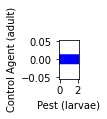

In [9]:
fig, ax = plt.subplots(figsize=(1, 1))

ax.plot(S, P, linestyle="-", linewidth=10, markersize=12,color="b")

plt.xlabel("Pest (larvae)")
plt.ylabel("Control Agent (adult)")
plt.rcParams.update({'font.size': 30})

plt.tight_layout(pad=0)
plt.show()

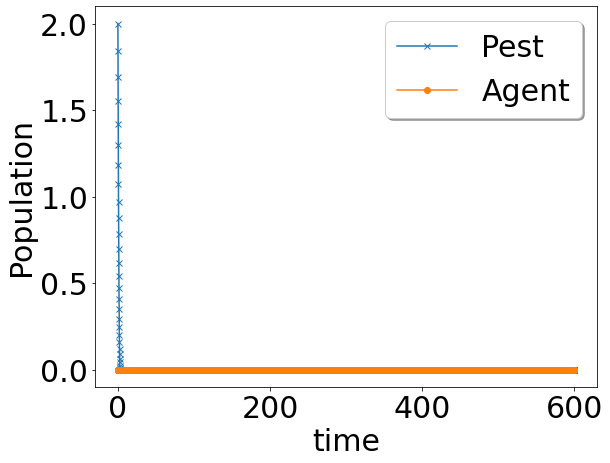

In [10]:
plt.figure(figsize=(9, 7))

plt.plot(time_list, S, '-x', label='Pest')
plt.plot(time_list, P, '-o', label='Agent')

plt.xlabel('time')
plt.ylabel('Population')

plt.legend(shadow=True)

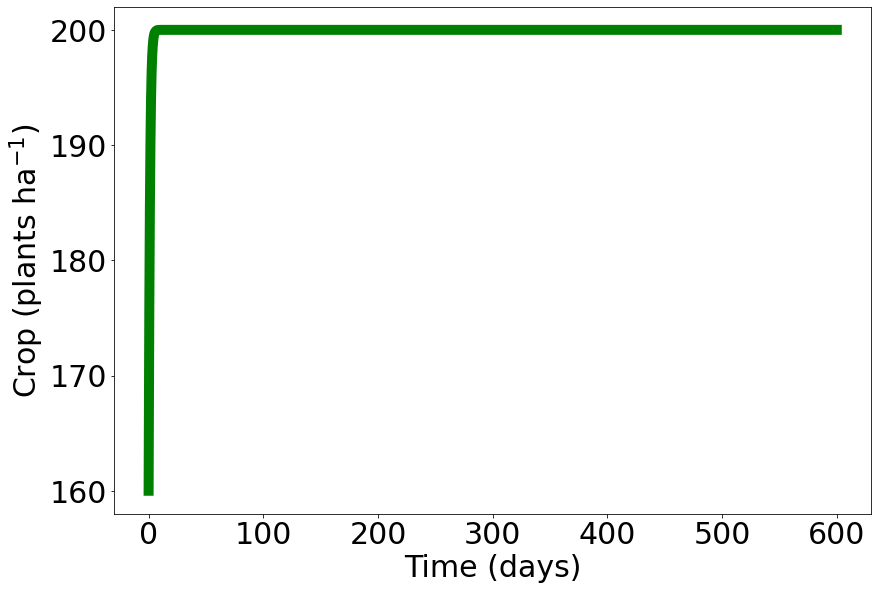

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, C+CBt, linestyle="-", linewidth=10, color="g") #label="Resource",

plt.xlabel("Time (days)")
plt.ylabel("Crop (plants $\mathregular{ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([155, 205])

plt.tight_layout(pad=0)
plt.savefig('img/structured_parasitism_resource.png', format='png')
plt.show()

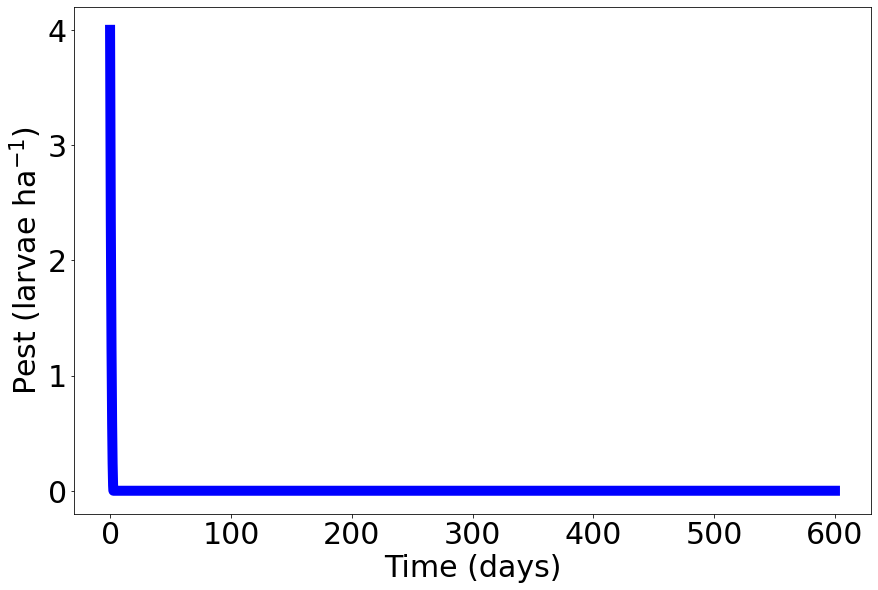

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, S+SBt, linestyle="-", linewidth=10, markersize=12,color="b") #, label="Pest"

plt.xlabel("Time (days)")
plt.ylabel("Pest (larvae $\mathregular{ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 330])

plt.savefig('img/structured_parasitism_pest.png', format='png', bbox_inches = 'tight')
plt.tight_layout(pad=0)
plt.show()

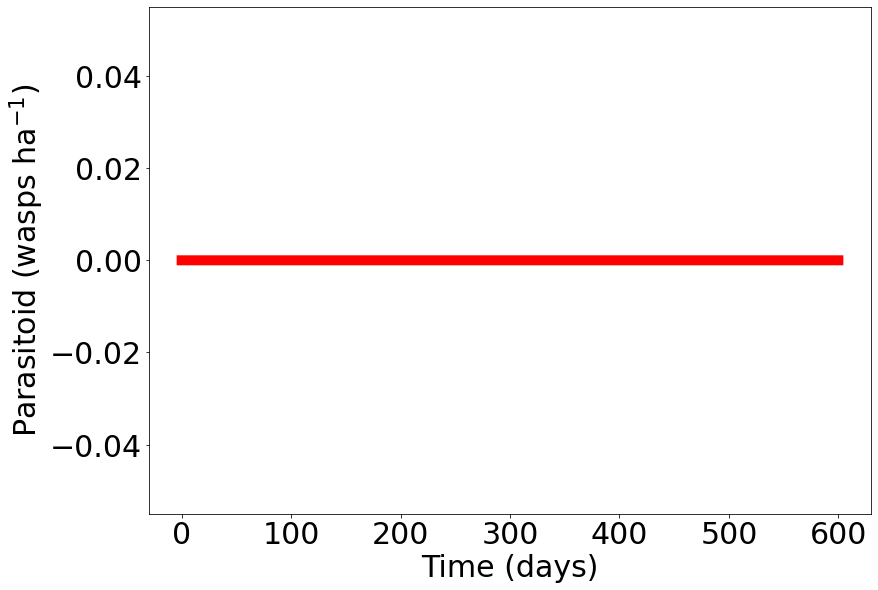

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(time_list, P, linestyle="-", linewidth=10, markersize=12,color="r") #, label="Control Agent"

plt.xlabel("Time (days)")
plt.ylabel("Parasitoid (wasps $\mathregular{ha^{-1}}$)")
plt.rcParams.update({'font.size': 30})

#plt.ylim([0, 1])

plt.savefig('img/structured_parasitism_agent.png', format='png', bbox_inches = 'tight')
plt.tight_layout(pad=0)
plt.show()

# Sensitivity Analyses

In [14]:
mean_values_params = [
    r,
    K,
    aS,
    hS,
    KBt,
    aP,
    alpha,
    qS,
    mBt,
    mP,
]
factors_names = [
    r"$\mathregular{r}$",
    r"$\mathregular{K}$",
    r"$\mathregular{a_S}$",
    r"$\mathregular{h_S}$",
    r"$\mathregular{K_{Bt}}$",
    r"$\mathregular{a_P}$",
    r"$\mathregular{\alpha}$",
    r"$\mathregular{q_S}$",
    r"$\mathregular{m_{Bt}}$",
    r"$\mathregular{m_P}$",
]
params_perturbations = 0.1
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 100
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=True, seed=seed)

In [15]:
t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0
time_list_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_list_points = time_list_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_list_points])

for realization_index, parameter_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_structured_parasitism = structured_parasitism_ode_solver(
        y0, 
        (t0, tf + days_to_forecast), 
        time_list_range, 
        *parameter_realization
    )
    C_realization,CBt_realization,S_realization,SBt_realization,P_realization = realization_ODE_structured_parasitism.y
    
    qoi_sensitivity_outputs[realization_index, :] = (C_realization + CBt_realization)

  0%|          | 0/44 [00:00<?, ?it/s]<ipython-input-5-d53b35445dd5>:27: RuntimeWarning: invalid value encountered in double_scalars
  S_prime=aS*C*S/(1+hS*C)-aP*S**alpha-qS*S**2
<ipython-input-5-d53b35445dd5>:28: RuntimeWarning: invalid value encountered in double_scalars
  SBt_prime=aS*CBt*SBt/(1+hS*CBt)-aP*SBt**alpha-qS*SBt**2-mBt*SBt
<ipython-input-5-d53b35445dd5>:30: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(S**alpha+SBt**alpha)*P-mP*P+RP
100%|██████████| 44/44 [00:02<00:00, 17.11it/s]


In [16]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['time_list', *problem_info['names']])
df_Si['time_list'] = time_list_range
df_sigmai['time_list'] = time_list_range
for time_list_point in tqdm(range(num_of_time_list_points)):
#    try:
    Si = ee_analyze(
        problem_info, 
        parameter_values, 
        qoi_sensitivity_outputs[:, time_list_point], 
        num_levels=grid_level, 
        seed=seed
    )
    # Some parameters combinations may result in simulation failure.
    # This if skip such cases, since they do not have associated sensitivity indicies
    if np.isnan(Si["mu"][-1]):
        continue
        
    Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
    sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
    for idx, param_name in enumerate(problem_info['names']):
        df_Si.loc[time_list_point, param_name] = Si['mu_star_normalized'][idx]
        df_sigmai.loc[time_list_point, param_name] = sigmai_normalized[idx]
#    except:
#        continue

df_Si.dropna(inplace=True)  # remove values that calculation was not possible
df_Si.sort_values(by='time_list', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='time_list', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_time_lists = df_Si.time_list.values
df_Si

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-16-d947ffda287e>:22: RuntimeWarning: invalid value encountered in true_divide
  sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
100%|██████████| 100/100 [00:00<00:00, 150.44it/s]


,time_list,$\mathregular{r}$,$\mathregular{K}$,$\mathregular{a_S}$,$\mathregular{h_S}$,$\mathregular{K_{Bt}}$,$\mathregular{a_P}$,$\mathregular{\alpha}$,$\mathregular{q_S}$,$\mathregular{m_{Bt}}$,$\mathregular{m_P}$
0,6.060606,0.00385095,0.0496545,0.000151691,0.000303281,0.945455,0.000217391,9.47595e-05,0.000106413,0.000166063,0
1,12.121212,2.89907e-05,0.0499843,6.5598e-06,1.27851e-05,0.949873,2.72562e-05,1.50655e-05,1.99558e-05,3.19844e-05,0
2,18.181818,2.61545e-05,0.0499761,2.53004e-06,3.65588e-05,0.949812,2.67289e-05,6.57352e-06,3.80094e-05,7.54443e-05,0
3,24.242424,7.40527e-05,0.0499778,2.78376e-05,5.09809e-05,0.949733,1.8863e-05,1.62522e-05,1.01584e-05,9.06023e-05,0
4,30.303030,2.65405e-05,0.0499843,1.32648e-05,4.86827e-05,0.949689,1.84639e-05,4.37136e-05,6.39705e-05,0.000112235,0
...,...,...,...,...,...,...,...,...,...,...,...
94,575.757576,1.52549e-05,0.0500048,4.38772e-06,3.02063e-05,0.949894,4.76295e-06,1.30478e-05,8.9069e-06,2.42043e-05,0
95,581.818182,1.38949e-05,0.0500049,4.42188e-06,3.18773e-05,0.949893,4.2501e-06,1.29244e-05,9.21013e-06,2.5826e-05,0
96,587.878788,1.22063e-05,0.050005,4.50288e-06,3.38278e-05,0.94989,3.81241e-06,1.31277e-05,1.09295e-05,2.63433e-05,0
97,593.939394,1.01696e-05,0.0500047,4.62001e-06,3.60277e-05,0.949881,2.78972e-06,1.38725e-05,1.49787e-05,3.21072e-05,0


In [17]:
df_sigmai

,time_list,$\mathregular{r}$,$\mathregular{K}$,$\mathregular{a_S}$,$\mathregular{h_S}$,$\mathregular{K_{Bt}}$,$\mathregular{a_P}$,$\mathregular{\alpha}$,$\mathregular{q_S}$,$\mathregular{m_{Bt}}$,$\mathregular{m_P}$
0,6.060606,0.402325,0.0623372,0.0306882,0.0934645,0.260704,0.0647533,0.00697592,0.031643,0.0471086,0
1,12.121212,0.17333,0.103865,0.0516752,0.0551174,0.0845581,0.165,0.0939138,0.103857,0.168683,0
2,18.181818,0.120724,0.0465732,0.0063952,0.143217,0.108633,0.0868311,0.0252007,0.176482,0.285944,0
3,24.242424,0.16446,0.137672,0.065831,0.16555,0.067892,0.0427677,0.0528328,0.0373051,0.26569,0
4,30.303030,0.0610308,0.226449,0.0484767,0.11512,0.0783387,0.0203972,0.129939,0.169809,0.15044,0
...,...,...,...,...,...,...,...,...,...,...,...
94,575.757576,0.0700685,0.181492,0.0405083,0.33626,0.027523,0.0262093,0.0880658,0.0692852,0.160587,0
95,581.818182,0.0613257,0.184781,0.0414558,0.342736,0.0288131,0.0169671,0.0891345,0.0694331,0.165353,0
96,587.878788,0.0523989,0.186262,0.042297,0.345839,0.0347249,0.0114713,0.0922311,0.0729407,0.161835,0
97,593.939394,0.0433707,0.183643,0.0425076,0.341324,0.0407408,0.010675,0.0946942,0.0909835,0.152062,0


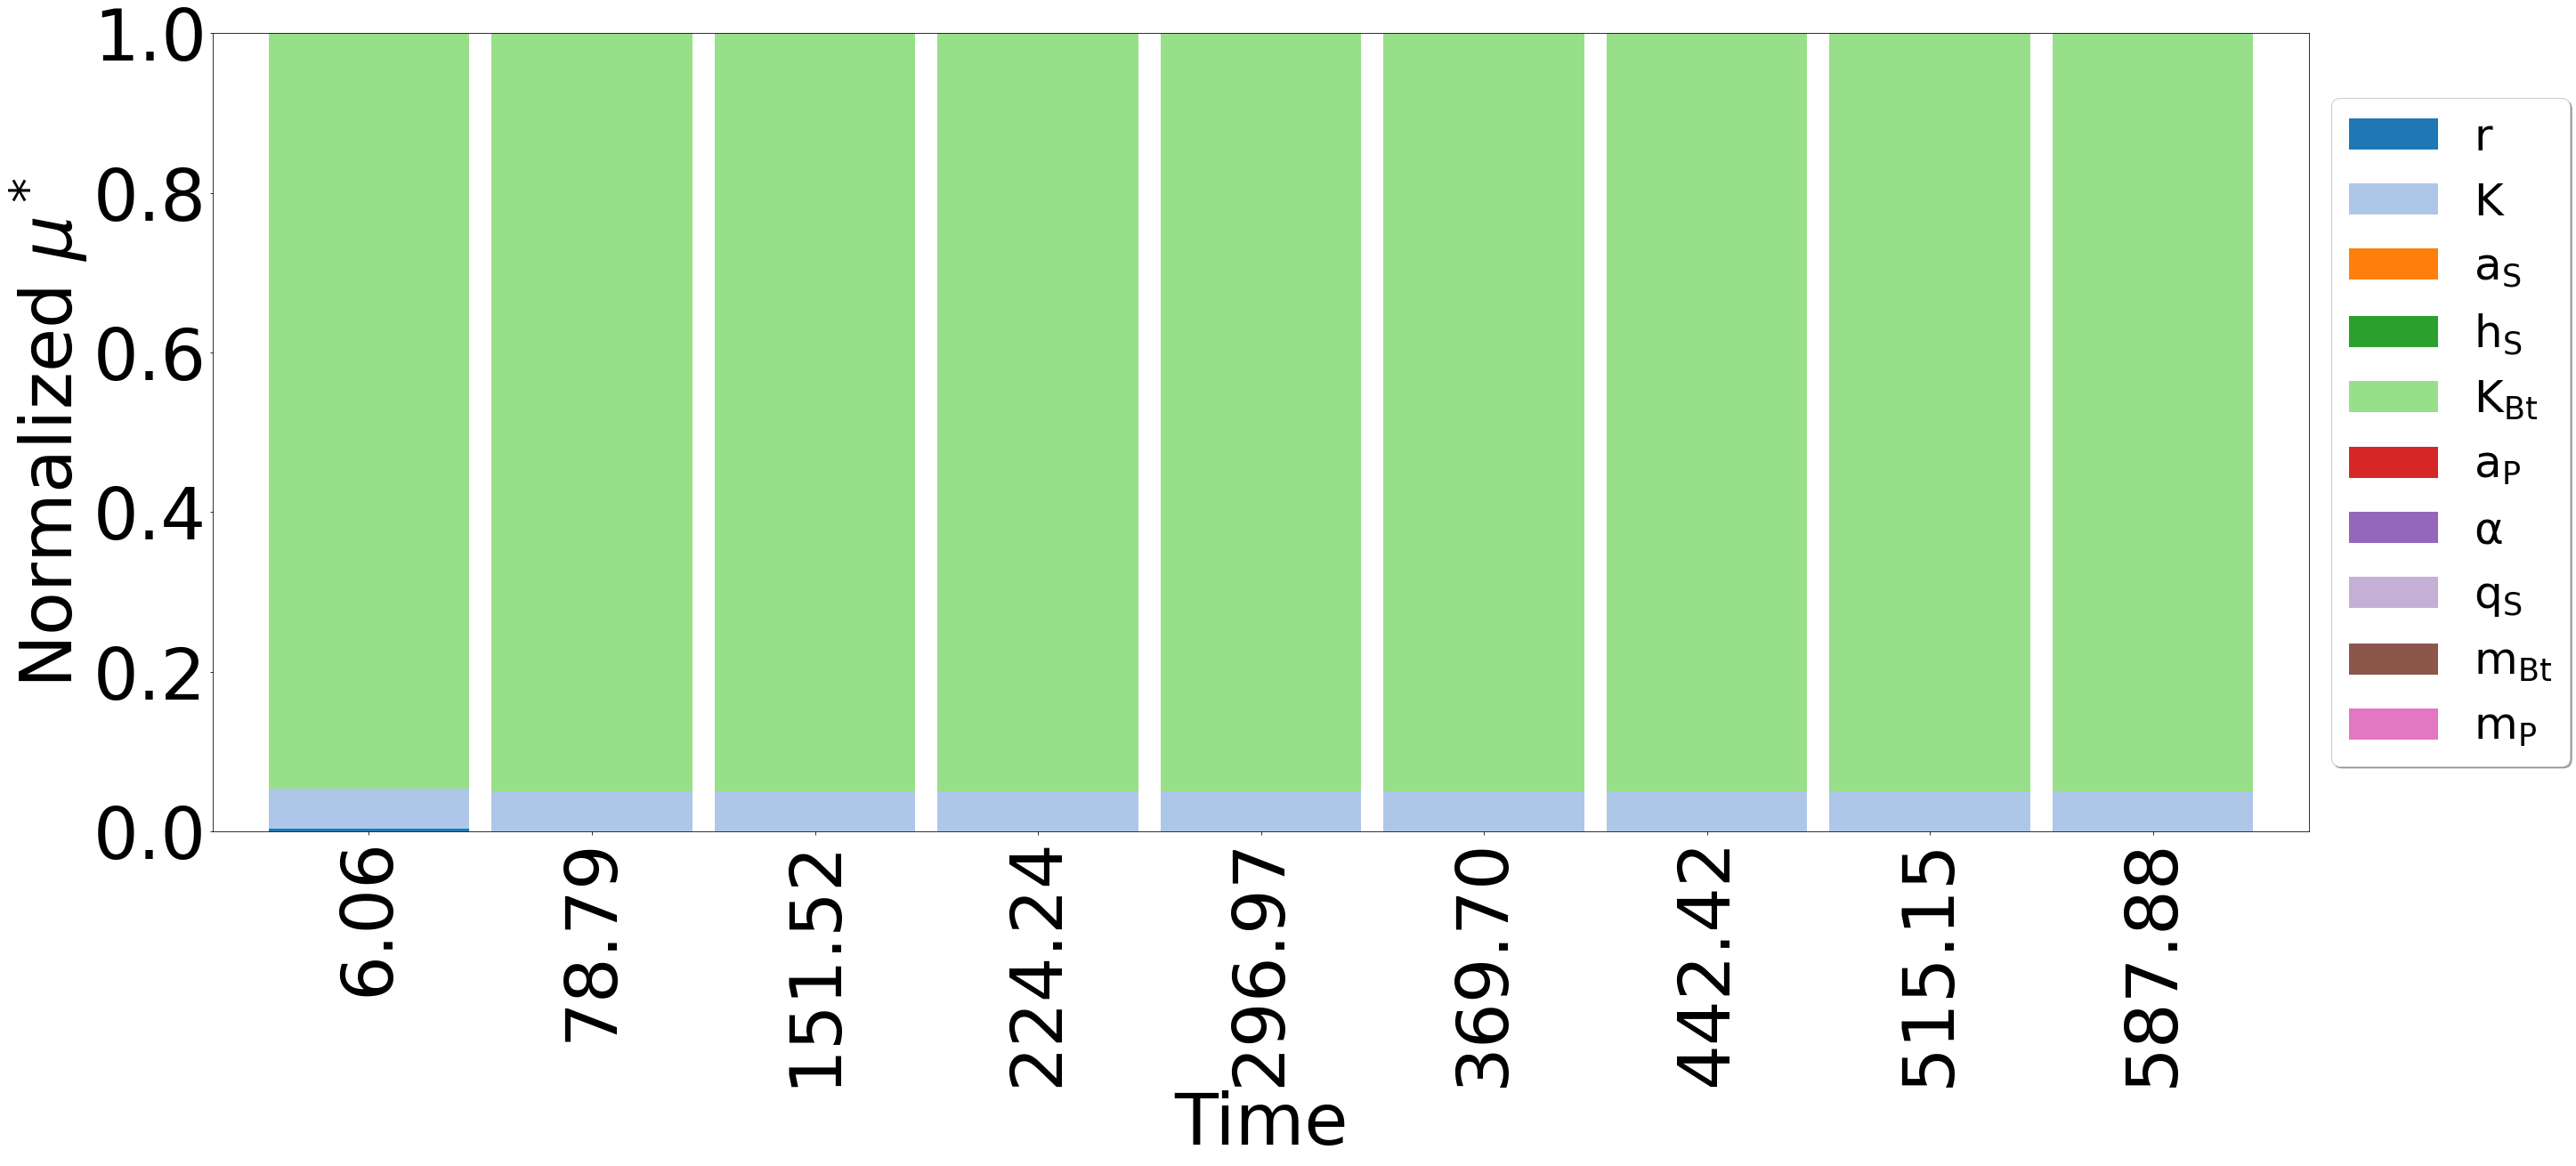

In [18]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_mu = valid_time_lists[::step_to_plot]

#colors = sns.color_palette("coolwarm",16)
colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_Si[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_mu[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\mu^*$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True, fontsize=50)

plt.tight_layout(pad=0)
plt.savefig("img/SA_structured_parasitism_mu.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

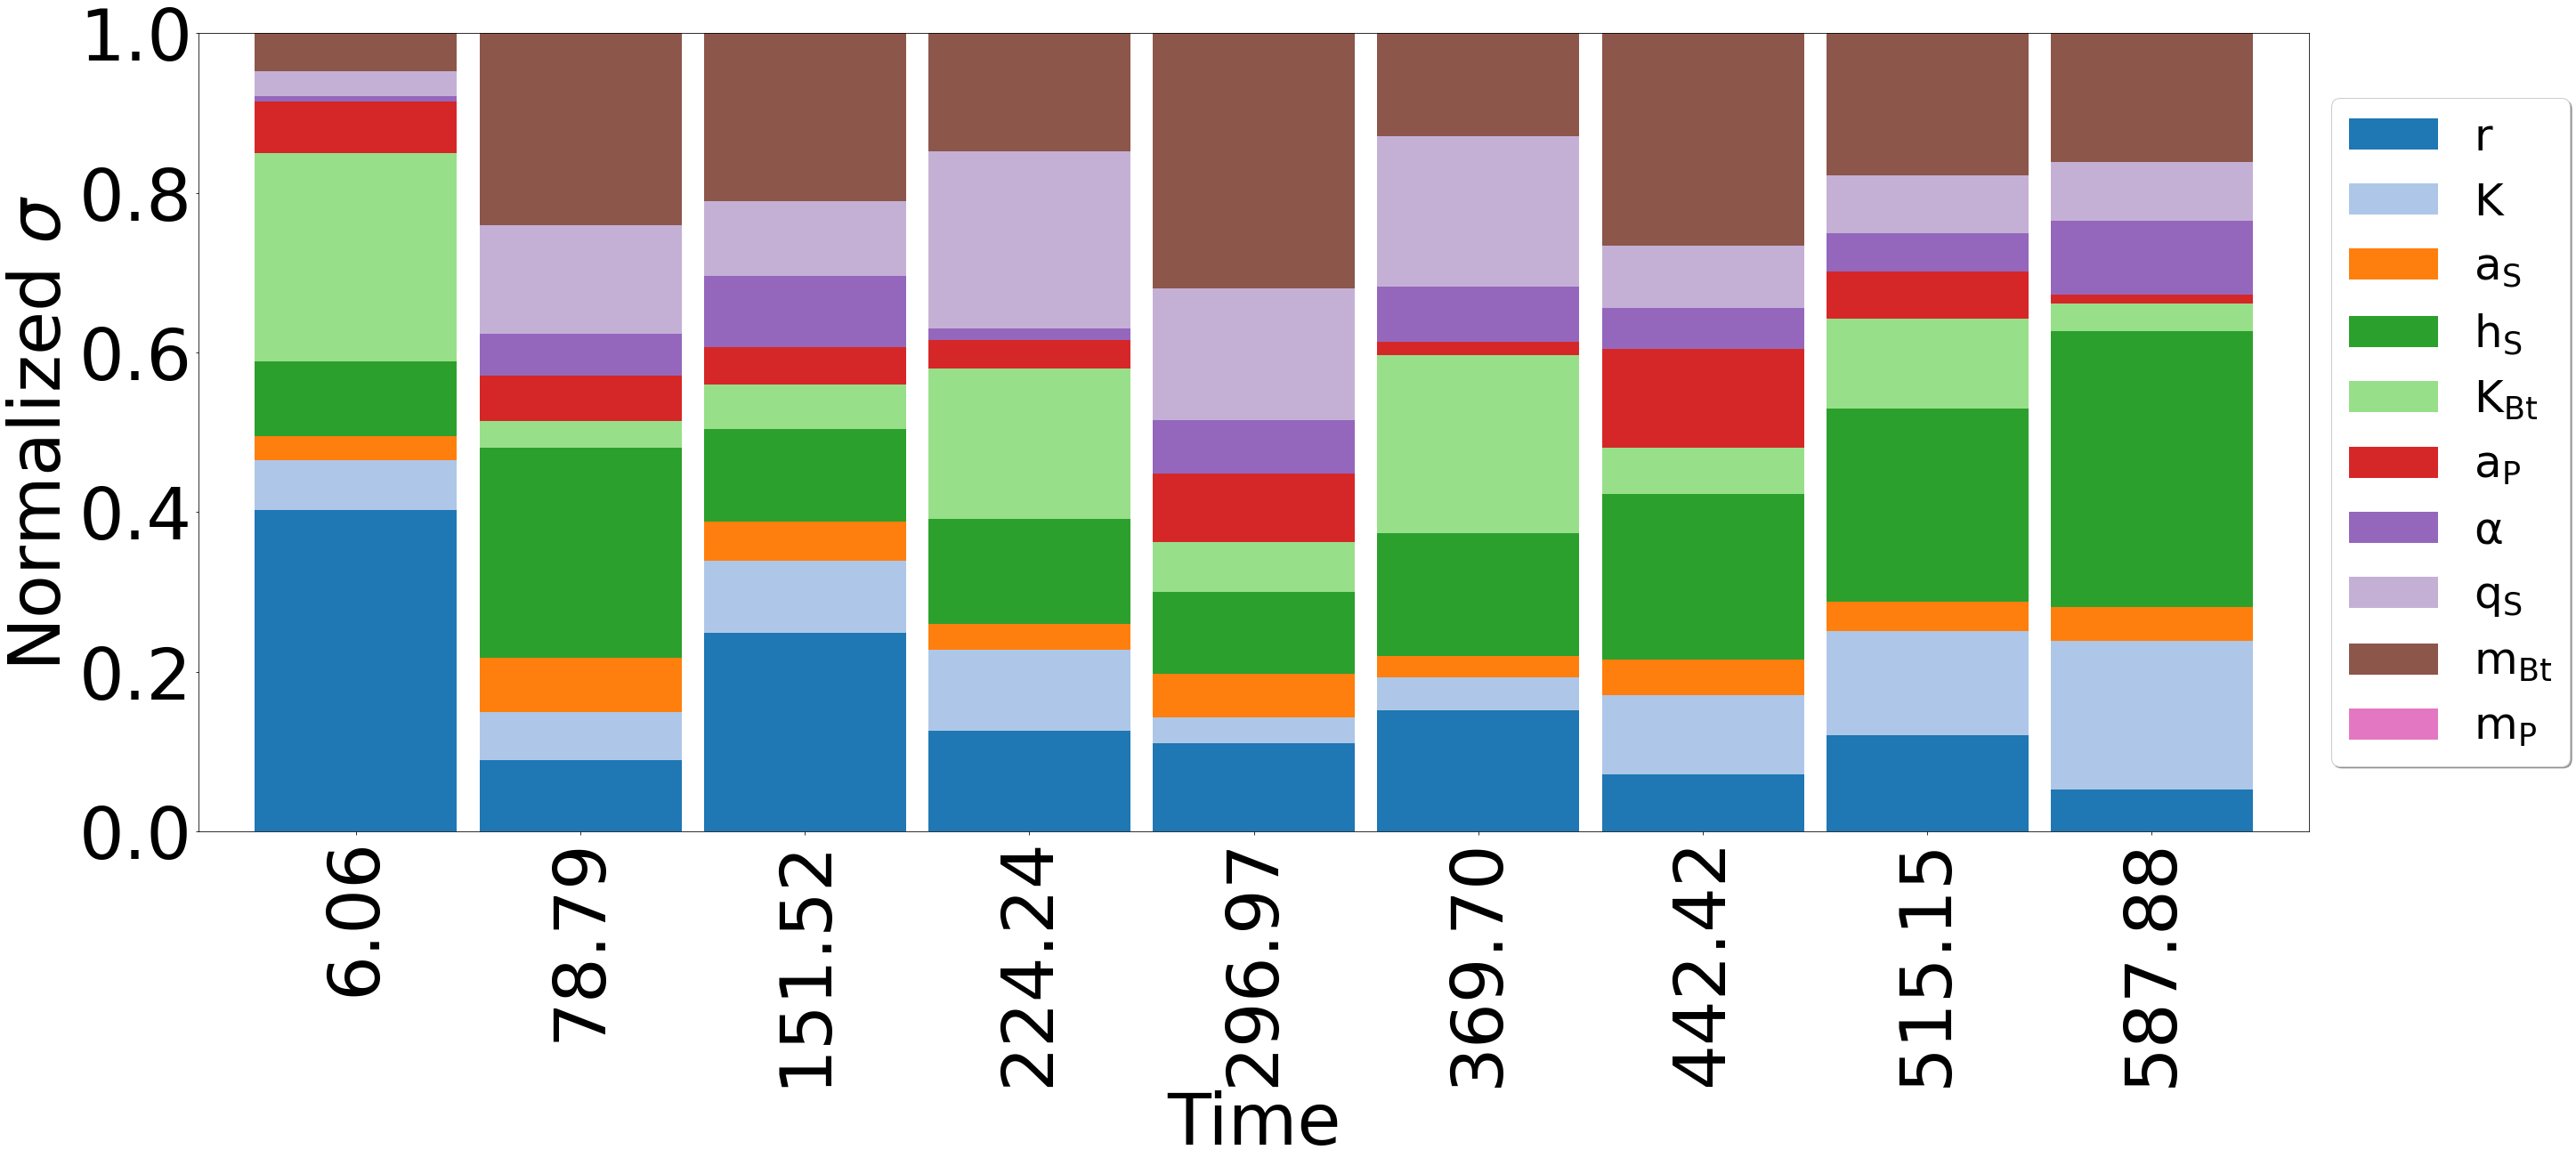

In [19]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 12
valid_time_lists_to_plot_sigma = valid_time_lists[::step_to_plot]

#colors = sns.color_palette("coolwarm",16)
colors =  plt.cm.tab20( (4./3*np.arange(20*3/4)).astype(int) )
ax.set_prop_cycle('color', colors)

df_sigmai[::step_to_plot].plot.bar(x='time_list', rot=90, width=0.9, figsize=(40, 18), stacked=True, ax=ax, color=colors)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_time_lists_to_plot_sigma[x]:.2f}")
plt.xlabel("Time", fontsize = 80)
plt.ylabel(r"Normalized $\sigma$", fontsize = 80)

plt.xticks(fontsize=80)
plt.yticks(fontsize=80)

plt.ylim([0, 1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True, fontsize=50)

plt.tight_layout(pad=0)
plt.savefig("img/SA_structured_parasitism_sigma.png", format='png', bbox_inches = 'tight', dpi=50)
plt.show()

# Continuation diagram

In [20]:
plt.rcParams.update({'font.size': 8})

tmax = 5000
step = tmax*10
time_list = np.linspace(0, tmax, step)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

## Repeat cell 5

In [21]:
def structured_parasitism_model(
    t,
    X,
    r=r,
    K=K,
    aS=aS,
    hS=hS,
    KBt=KBt,
    aP=aP,
    alpha=alpha,
    qS=qS,
    mBt=mBt,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    C,CBt,S,SBt,P = X
#    C: crop
#    CBt: genetically modified Bt crop
#    S: pest
#    S: pest in Bt
#    P: parasitoid of egg (biocontrol agent)
    C_prime=r*C*(1-C/K)-aS*C*S/(1+hS*C)
    CBt_prime=r*CBt*(1-CBt/KBt)-aS*CBt*SBt/(1+hS*CBt)
    S_prime=aS*C*S/(1+hS*C)-aP*S**alpha-qS*S**2
    SBt_prime=aS*CBt*SBt/(1+hS*CBt)-aP*SBt**alpha-qS*SBt**2-mBt*SBt
    RP=RP_function(t,sig,S,bound)
    P_prime=aP*(S**alpha+SBt**alpha)*P-mP*P+RP
#    return C_prime,CBt_prime,E_prime,EBt_prime,L_prime,LBt_prime,A_prime,P_prime
    return np.nan_to_num(C_prime),np.nan_to_num(CBt_prime),np.nan_to_num(S_prime),np.nan_to_num(SBt_prime),np.nan_to_num(P_prime)

def structured_parasitism_ode_solver(
    y0,
    t_span,
    t_eval,
    r=r,
    K=K,
    aS=aS,
    hS=hS,
    KBt=KBt,
    aP=aP,
    alpha=alpha,
    qS=qS,
    mBt=mBt,
    mP=mP,
    RP=RP,
    RP_function=inoculative_function,
    sig=sig,
    bound=bound,
):
    solution_ODE_structured_parasitism = solve_ivp(
        fun=structured_parasitism_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r,K,aS,hS,KBt,aP,alpha,qS,mBt,mP),
        method=method,
    )
    return np.nan_to_num(solution_ODE_structured_parasitism)

t0 = time_list.min()
tf = time_list.max()
days_to_forecast = 0

Running continuation:   0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-21-d53b35445dd5>:28: RuntimeWarning: invalid value encountered in double_scalars
  SBt_prime=aS*CBt*SBt/(1+hS*CBt)-aP*SBt**alpha-qS*SBt**2-mBt*SBt
<ipython-input-21-d53b35445dd5>:30: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(S**alpha+SBt**alpha)*P-mP*P+RP
<ipython-input-21-d53b35445dd5>:27: RuntimeWarning: invalid value encountered in double_scalars
  S_prime=aS*C*S/(1+hS*C)-aP*S**alpha-qS*S**2
Plotting results: 100%|██████████| 5/5 [00:00<00:00, 34.86it/s]
<ipython-input-22-058be0ad0b44>:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


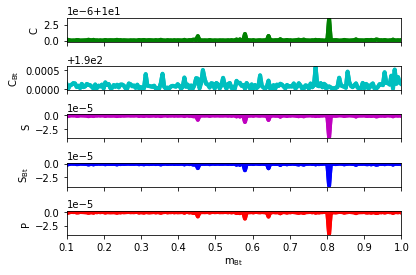

In [22]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            if np.isnan(output_variable_last_results[-1]):
                continue
            if output_variable_last_results[-1]<0:
                continue
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aS": aS,
    "hS": hS,
    "KBt": KBt,
    "aP": aP,
    "alpha": alpha,
    "qS": qS,
#    "mBt": mBt,
    "mP": mP,
}


mBt_min = 0.1
mBt_max = 1
mBt_points = np.linspace(mBt_min, mBt_max, num_of_points)
parameter_to_continuation = {"mBt": mBt_points}

mBt_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="mBt",
    parameter_span=(mBt_min, mBt_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","S","$\mathregular{S_{Bt}}$","P"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","m","b","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        mBt_values["mBt"], variable_result, color=color, alpha=1, linewidth=4
    )

    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{m_{Bt}}$", ylabel=f"{variable_name}", xlim=(mBt_min, mBt_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.tight_layout(pad=0)
plt.savefig("img/continuation_mBt.png", format='png', bbox_inches = "tight", dpi=300)
plt.show()

Running continuation:  27%|██▋       | 54/200 [00:03<00:11, 12.44it/s]<ipython-input-21-d53b35445dd5>:28: RuntimeWarning: invalid value encountered in double_scalars
  SBt_prime=aS*CBt*SBt/(1+hS*CBt)-aP*SBt**alpha-qS*SBt**2-mBt*SBt
<ipython-input-21-d53b35445dd5>:30: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(S**alpha+SBt**alpha)*P-mP*P+RP
Running continuation:  30%|███       | 61/200 [00:04<00:15,  8.71it/s]<ipython-input-21-d53b35445dd5>:27: RuntimeWarning: invalid value encountered in double_scalars
  S_prime=aS*C*S/(1+hS*C)-aP*S**alpha-qS*S**2
Plotting results: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]
<ipython-input-23-4eae9fef51d1>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


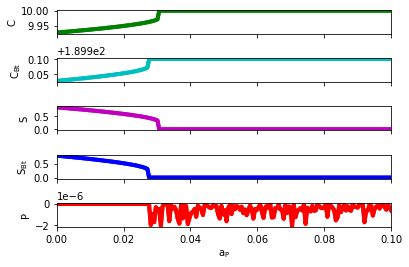

In [23]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            if np.isnan(output_variable_last_results[-1]):
                continue
            if output_variable_last_results[-1]<0:
                continue
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aS": aS,
    "hS": hS,
    "KBt": KBt,
#    "aP": aP,
    "alpha": alpha,
    "qS": qS,
    "mBt": mBt,
    "mP": mP,
}


aP_min = 0
aP_max = 0.1
aP_points = np.linspace(aP_min, aP_max, num_of_points)
parameter_to_continuation = {"aP": aP_points}

aP_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="aP",
    parameter_span=(aP_min, aP_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","S","$\mathregular{S_{Bt}}$","P"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","m","b","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        aP_values["aP"], variable_result, color=color, alpha=1, linewidth=4
    )

    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{a_P}$", ylabel=f"{variable_name}", xlim=(aP_min, aP_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

#fig.subplots_adjust(hspace=0.3)

plt.tight_layout(pad=0)
plt.savefig("img/continuation_aP.png", format='png', bbox_inches = "tight", dpi=300)
plt.show()

Running continuation:   0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-21-d53b35445dd5>:27: RuntimeWarning: invalid value encountered in double_scalars
  S_prime=aS*C*S/(1+hS*C)-aP*S**alpha-qS*S**2
<ipython-input-21-d53b35445dd5>:28: RuntimeWarning: invalid value encountered in double_scalars
  SBt_prime=aS*CBt*SBt/(1+hS*CBt)-aP*SBt**alpha-qS*SBt**2-mBt*SBt
<ipython-input-21-d53b35445dd5>:30: RuntimeWarning: invalid value encountered in double_scalars
  P_prime=aP*(S**alpha+SBt**alpha)*P-mP*P+RP
Plotting results: 100%|██████████| 5/5 [00:00<00:00, 30.98it/s]
<ipython-input-24-f635d9d2a273>:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


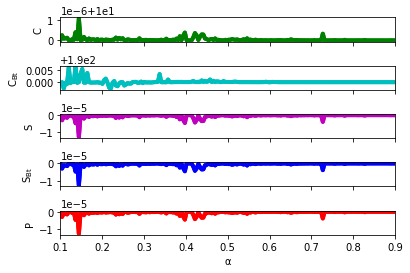

In [24]:
def run_continuation_analysis(
    ode_solver_wrapper,
    continuation_variable_name,
    parameter_span,
    parameter_num_of_points,
    fixed_parameters_dict,
    initial_conditions,
    output_variable_name_list,
    num_of_last_outcomes,
):
    if type(continuation_variable_name) != str:
        raise ValueError("Input continuation_variable_name must be of str type.")

    if type(parameter_num_of_points) != int:
        raise ValueError("Input parameter_num_of_points must be of integer type.")

    parameter_span_type = type(parameter_span)
    if parameter_span_type != tuple and parameter_span_type != list:
        raise ValueError("Input parameter_span must be a list or tuple of values.")
    else:
        if len(parameter_span) != 2:
            raise ValueError("Input parameter_span must be a list or tuple with two values.")

    if len(initial_conditions) != len(output_variable_name_list):
        raise ValueError(
            "The number of output variables from ODE model must be equal to number of initial conditions."
        )

    parameter_values = np.linspace(parameter_span[0], parameter_span[1], parameter_num_of_points)
    continuation_parameter_values_dict = {continuation_variable_name: parameter_values}
    time_values = time_list

    # Creating dictionary to record continuation realizations
    output_variables_dict = dict()
    for output_variable_name in output_variable_name_list:
        output_variables_dict[output_variable_name] = list()

    # Running continuation evaluations
    parameter_progress_bar = tqdm(parameter_values)
    for parameter_value in parameter_progress_bar:
        parameter_progress_bar.set_description("Running continuation")
        parameters = fixed_parameters
        parameters[continuation_variable_name] = parameter_value
        ode_solver_output = ode_solver_wrapper(initial_conditions, (t0, tf + days_to_forecast), time_values, **parameters)
        t_output, y_output = ode_solver_output.t, ode_solver_output.y
        y_last_outputs = y_output[:, -num_of_last_outcomes:]
        output_index = 0
        for output_variable_name in output_variable_name_list:
            output_variable_last_results = y_last_outputs[output_index]
            output_variables_dict[output_variable_name].append(
                [output_variable_last_results.min(), output_variable_last_results.max()]
            )
            if np.isnan(output_variable_last_results[-1]):
                continue
#            print("antes: ",output_variable_last_results[-1])
            if output_variable_last_results[-1]<0:
                continue
#            print("depois: ",output_variable_last_results[-1])
            output_index += 1

    return continuation_parameter_values_dict, output_variables_dict

fixed_parameters = {
    "r": r,
    "K": K,
    "aS": aS,
    "hS": hS,
    "KBt": KBt,
    "aP": aP,
#    "alpha": alpha,
    "qS": qS,
    "mBt": mBt,
    "mP": mP,
}


alpha_min = 0.1
alpha_max = 0.9
alpha_points = np.linspace(alpha_min, alpha_max, num_of_points)
parameter_to_continuation = {"alpha": alpha_points}

alpha_values, y_last_results = run_continuation_analysis(
    ode_solver_wrapper=structured_parasitism_ode_solver,
    continuation_variable_name="alpha",
    parameter_span=(alpha_min, alpha_max),
    parameter_num_of_points=num_of_points,
    fixed_parameters_dict=fixed_parameters,
    initial_conditions=y0,
    output_variable_name_list=["C","$\mathregular{C_{Bt}}$","S","$\mathregular{S_{Bt}}$","P"],
    num_of_last_outcomes=100,
)

colors_list = ["g","c","m","b","r"]
results_progress_bar = tqdm(y_last_results)
num_of_state_variables = len(y_last_results)
fig, axs = plt.subplots(num_of_state_variables, sharex=True, gridspec_kw={"hspace": 1})
index = 0
for variable_name in results_progress_bar:
    results_progress_bar.set_description("Plotting results")
    variable_result = np.array(y_last_results[variable_name])
    variable_min_values = variable_result[:, 0].astype(np.int)
    variable_max_values = variable_result[:, 1].astype(np.int)

    color = colors_list[index]
    axs[index].plot(
        alpha_values["alpha"], variable_result, color=color, alpha=1, linewidth=4
    )
#    ax.annotate(s=str(variable_name), xy=(.4,.4), fontsize=16)
    index += 1

for ax, variable_name in zip(axs.flat, y_last_results):
    ax.set(xlabel=r"$\mathregular{\alpha}$", ylabel=f"{variable_name}", xlim=(alpha_min, alpha_max))
    ax.plot(linewidth=15, markersize=20)
    ax.label_outer()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['lines.linewidth'] = MEDIUM_SIZE
plt.rcParams.update({'font.size': MEDIUM_SIZE})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.tight_layout(pad=0)
plt.savefig("img/continuation_alpha.png", format='png', bbox_inches = "tight", dpi=300)
plt.show()